 Celem zadania jest przewidzieć czy pacjent z cukrzycą zostanie odesłany do szpitala w ciągu 30 dni, czyli kolumna `readmitted`.

 Metryką sukcesu jest **RMSLE**.
 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install scikit-plot

In [4]:
pip install catboost

     |████████████████████████████████| 76.3 MB 1.2 MB/s 


In [5]:
pip install ml_metrics

  Created wheel for ml-metrics: filename=ml_metrics-0.1.4-py3-none-any.whl size=7845 sha256=a5b7a7a39127b8ae44e1ec2975dd3c77826535b74fa465118005c723b6faaaf7
  Stored in directory: /root/.cache/pip/wheels/56/41/5b/0c6d42b3604a5c823d8922564c4708f84962fa7f2f4facfa6d
Successfully built ml-metrics


In [6]:
import pandas as pd
import numpy as np
np.random.seed(2019)

from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit, learning_curve, cross_val_score
#from scikitplot.estimators import plot_learning_curve
from sklearn.model_selection import ShuffleSplit
import scikitplot as skplt
import seaborn as sns

import xgboost as xgb
import lightgbm as lgb
import catboost as ctb
    
import matplotlib.pyplot as plt
%matplotlib inline

from ml_metrics import rmsle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import gc
import sys

In [7]:
pip install --upgrade tables

     |████████████████████████████████| 5.9 MB 4.5 MB/s 
  Attempting uninstall: tables
    Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


## Dane

In [8]:
train = pd.read_hdf('/content/drive/MyDrive/Colab_Notebooks/PML/modules/module3/input/diabetic_train.h5')
test = pd.read_hdf('/content/drive/MyDrive/Colab_Notebooks/PML/modules/module3/input/diabetic_test.h5')
train.shape, test.shape

((33051, 51), (33170, 51))

In [9]:
df_all = pd.concat([train, test])
df_all.shape

(66221, 51)

In [10]:
del train, test
import gc
gc.collect()

271

In [11]:
df_all.sample(10)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,id
33213,105238902,93379203,Caucasian,Female,[90-100),[50-75),1,4,7,6,MC,InternalMedicine,63,2,8,1,0,0,599,707,424,9,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,0,33213
84750,267557436,81385569,Caucasian,Male,[70-80),?,1,1,7,1,MC,?,30,0,15,0,0,0,512,493,162,9,None,None,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,False,True,100,84750
43319,133745040,113708169,Caucasian,Female,[70-80),?,1,2,7,1,MC,InternalMedicine,84,0,9,0,0,0,414,780,785,9,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,False,True,0,43319
12880,51883632,18790479,Caucasian,Male,[60-70),?,1,1,7,3,?,Emergency/Trauma,46,0,8,0,0,0,491,599,250.02,7,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,False,True,,12880
100503,426688028,57602340,Caucasian,Female,[80-90),?,1,1,7,5,?,InternalMedicine,55,2,22,1,0,0,427,427,401,7,None,None,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,True,True,0,100503
40601,125968290,89929269,Caucasian,Female,[50-60),?,2,1,7,2,UN,Emergency/Trauma,1,0,10,0,0,0,560,599,250,4,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,0,40601
30589,98792442,60561144,Caucasian,Female,[70-80),?,1,1,7,7,?,InternalMedicine,68,3,27,0,0,2,404,428,427,9,None,None,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,True,True,0,30589
100072,420863300,78183432,Caucasian,Female,[80-90),?,1,3,7,2,MC,?,23,0,23,3,0,2,786,414,412,9,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,False,True,,100072
49878,150447222,41149971,Caucasian,Male,[70-80),?,1,3,7,7,MC,?,63,0,24,0,0,0,728,593,428,8,None,None,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,True,True,100,49878
96455,375544070,48488967,Caucasian,Female,[70-80),?,2,1,1,8,?,Radiologist,29,1,17,0,1,2,440,425,454,9,None,None,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,True,True,0,96455


In [12]:
train = df_all[df_all.readmitted != ''].copy()

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33051 entries, 0 to 101765
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              33051 non-null  int32 
 1   patient_nbr               33051 non-null  int32 
 2   race                      33051 non-null  object
 3   gender                    33051 non-null  object
 4   age                       33051 non-null  object
 5   weight                    33051 non-null  object
 6   admission_type_id         33051 non-null  int8  
 7   discharge_disposition_id  33051 non-null  int8  
 8   admission_source_id       33051 non-null  int8  
 9   time_in_hospital          33051 non-null  int8  
 10  payer_code                33051 non-null  object
 11  medical_specialty         33051 non-null  object
 12  num_lab_procedures        33051 non-null  int16 
 13  num_procedures            33051 non-null  int8  
 14  num_medications      

In [14]:
train['readmitted'] = train['readmitted'].astype(np.int8)

In [15]:
cat_feats = train.select_dtypes(include=np.object).columns

for cat_feat in cat_feats:
    train['{0}_cat'.format(cat_feat)] = pd.factorize(train[cat_feat])[0]

cat_feats

Index(['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty',
       'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult'],
      dtype='object')

In [16]:
black_list = ['id', 'encounter_id', 'readmitted' ]

# 'patient_nbr'

In [17]:
train['change'] = train['change'].map(lambda x: 1 if x ==True else 0)
train['diabetesMed'] = train['diabetesMed'].map(lambda x: 1 if x ==True else 0)

In [18]:
train['change'].astype(float)
train['diabetesMed'].astype(float)

0         0.0
2         1.0
3         1.0
4         1.0
8         1.0
         ... 
101744    0.0
101746    1.0
101749    1.0
101759    1.0
101765    0.0
Name: diabetesMed, Length: 33051, dtype: float64

In [19]:
num_feats = train.select_dtypes(include=np.number).columns.values
num_feats = [feat for feat in num_feats if feat not in black_list]

In [20]:
num_feats

['patient_nbr',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'race_cat',
 'gender_cat',
 'age_cat',
 'weight_cat',
 'payer_code_cat',
 'medical_specialty_cat',
 'diag_1_cat',
 'diag_2_cat',
 'diag_3_cat',
 'max_glu_serum_cat',
 'A1Cresult_cat']

In [21]:
feats = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
         'time_in_hospital', 'num_lab_procedures', 'num_procedures', 
         'num_medications', 'number_outpatient', 'number_emergency', 
         'number_inpatient', 'number_diagnoses', 'metformin', 'repaglinide', 
         'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 
         'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
         'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
         'tolazamide', 'examide', 'citoglipton', 'insulin','glyburide-metformin', 
         'glipizide-metformin', 'glimepiride-pioglitazone', 
         'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 
         'diabetesMed', 'race_cat', 'gender_cat', 'age_cat', 'weight_cat', 
         'payer_code_cat', 'medical_specialty_cat', 'diag_1_cat', 'diag_2_cat', 
         'diag_3_cat', 'max_glu_serum_cat', 'A1Cresult_cat'
         ]

In [22]:
feats = [feat for feat in feats if feat not in (black_list)]

In [23]:
X = train[feats].values
y = train['readmitted'].values

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model = xgb.XGBClassifier(random_state=2000, n_estimators=100, max_depth=4)
%time model.fit(X_train, y_train)
%time y_pred = model.predict(X_test)

rmsle(y_test, y_pred)

CPU times: user 3.65 s, sys: 41.8 ms, total: 3.69 s
Wall time: 3.74 s
CPU times: user 43.3 ms, sys: 0 ns, total: 43.3 ms
Wall time: 42.1 ms


1.87

In [25]:
def plot_learning_curve(model, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

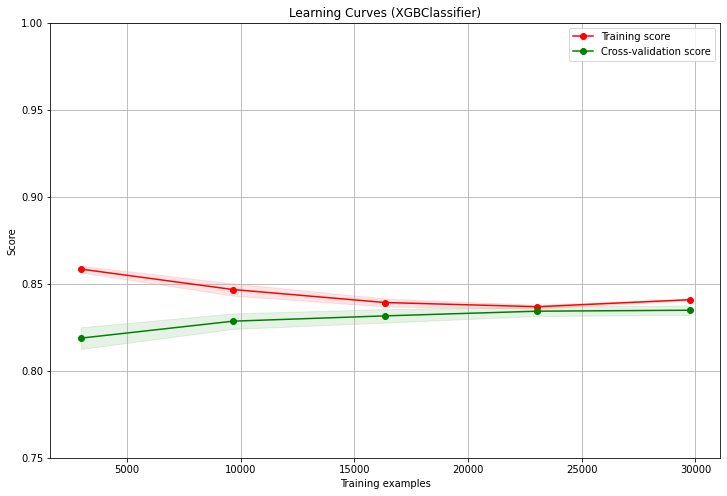

In [26]:
plt = plot_learning_curve(model, "Learning Curves (XGBClassifier)", X, y, ylim=(0.75, 1.0), cv=10, n_jobs=4)
plt.show()

In [27]:
def train_and_predict(model, X, y, success_metric = rmsle, test_size=0.3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2018)
    
    model.fit(X_train, y_train)    
    y_pred = model.predict(X_test) 

    return print(rmsle(y_test, y_pred))

def draw_feature_importances(model, features, name):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 5))
    plt.title("Feature importances for: " +  name )
    plt.bar(range(X.shape[1]), model.feature_importances_[indices],
           color="b", align="center")
    plt.xticks(range(X.shape[1]), [ features[x] for x in indices])
    plt.xticks(rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()

1.889


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

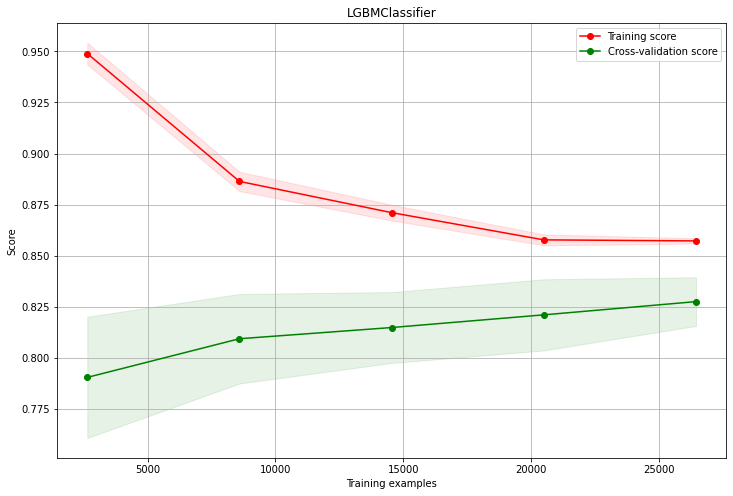

In [28]:
model = lgb.LGBMClassifier(max_depth=6, n_estimators=150, random_state=2000)
train_and_predict(model, X, y, success_metric = rmsle, test_size=0.3)
plot_learning_curve(model, "LGBMClassifier", X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))



Learning rate set to 0.224389
0:	learn: 0.5813280	total: 56.4ms	remaining: 8.41s
1:	learn: 0.5143311	total: 66.3ms	remaining: 4.91s
2:	learn: 0.4800082	total: 75.1ms	remaining: 3.68s
3:	learn: 0.4570157	total: 85ms	remaining: 3.1s
4:	learn: 0.4432604	total: 95.1ms	remaining: 2.76s
5:	learn: 0.4317175	total: 105ms	remaining: 2.51s
6:	learn: 0.4271213	total: 113ms	remaining: 2.31s
7:	learn: 0.4220420	total: 122ms	remaining: 2.17s
8:	learn: 0.4184269	total: 131ms	remaining: 2.05s
9:	learn: 0.4163900	total: 140ms	remaining: 1.96s
10:	learn: 0.4143171	total: 155ms	remaining: 1.96s
11:	learn: 0.4129412	total: 171ms	remaining: 1.97s
12:	learn: 0.4115472	total: 180ms	remaining: 1.9s
13:	learn: 0.4103308	total: 189ms	remaining: 1.84s
14:	learn: 0.4084967	total: 203ms	remaining: 1.82s
15:	learn: 0.4074426	total: 213ms	remaining: 1.78s
16:	learn: 0.4060873	total: 222ms	remaining: 1.74s
17:	learn: 0.4054801	total: 232ms	remaining: 1.7s
18:	learn: 0.4048418	total: 241ms	remaining: 1.66s
19:	learn: 

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

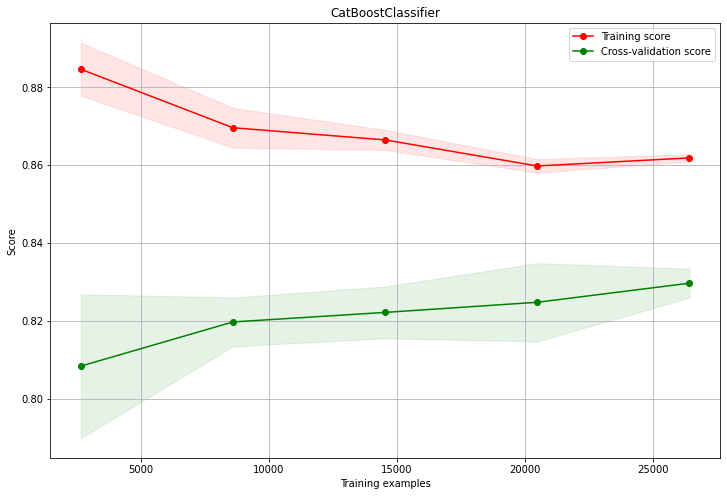

In [29]:
model = ctb.CatBoostClassifier(n_estimators=150, max_depth=6, random_state=2000)
train_and_predict(model, X, y, success_metric = rmsle, test_size=0.3)
plot_learning_curve(model, "CatBoostClassifier", X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))


1.912


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

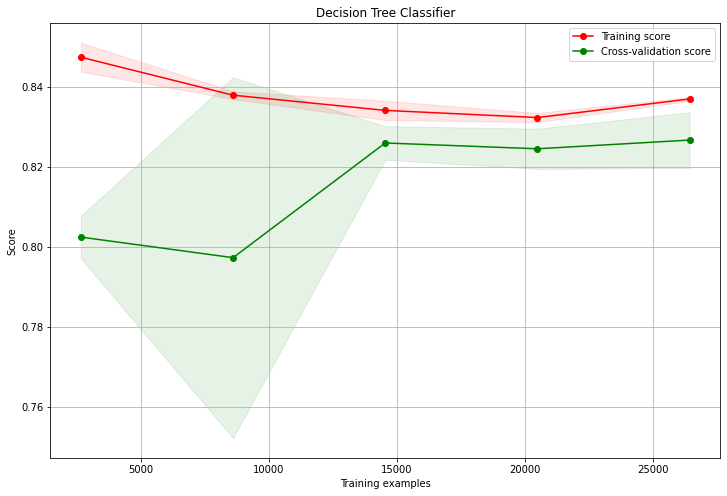

In [30]:
model = DecisionTreeClassifier(max_depth=6, random_state=2000)
train_and_predict(model, X, y, success_metric = rmsle, test_size=0.3)
plot_learning_curve(model, "Decision Tree Classifier", X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))



1.917


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

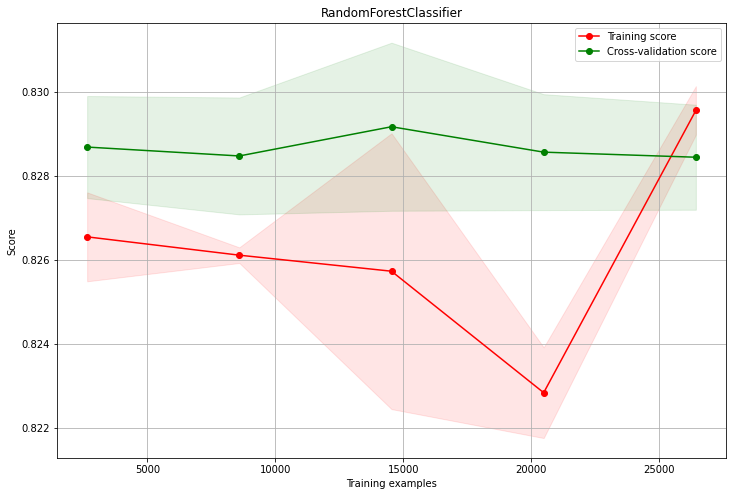

In [31]:
model = RandomForestClassifier(max_depth=6, n_estimators=150, random_state=2000)
train_and_predict(model, X, y, success_metric = rmsle, test_size=0.3)
plot_learning_curve(model, "RandomForestClassifier", X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))

## Feature engineering

#### Features without medicines

In [32]:
features_without_medicines = [
                              'admission_type_id', 'discharge_disposition_id', 
                              'admission_source_id', 'time_in_hospital', 
                              'num_lab_procedures', 'num_procedures', 
                              'num_medications', 'number_outpatient', 
                              'number_emergency', 'number_inpatient', 
                              'number_diagnoses'
                              ]


X = train[features_without_medicines].values
y = train['readmitted'].values


1.884


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

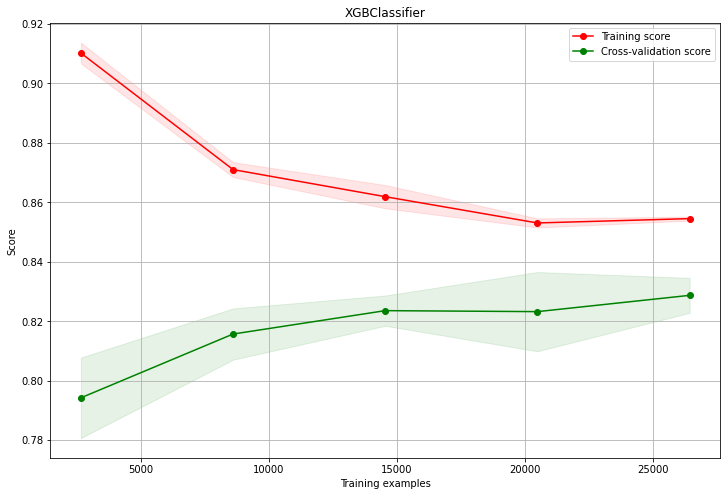

In [33]:
model = xgb.XGBClassifier(n_estimators=150, max_depth=6, random_state=2000)
train_and_predict(model, X, y, success_metric = rmsle, test_size=0.3)
plot_learning_curve(model, "XGBClassifier", X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))



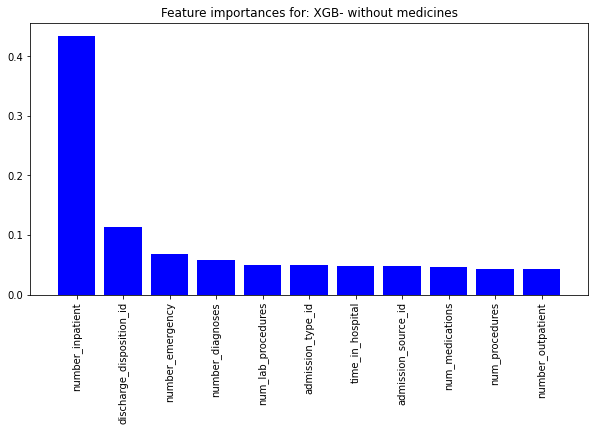

In [34]:
draw_feature_importances(model, features_without_medicines, "XGB- without medicines")

#### New features

In [35]:
train["age_above90"] = train['age'].map(lambda x: int(x == '[90-100)'))
train["age_above80"] = train['age'].map(lambda x: int( (x == '[90-100)') | (x == '[80-90)')))
train["age_above70"] = train['age'].map(lambda x: int( (x == '[90-100)') | (x == '[80-90)') | (x == '[70-80)')))
train["age_above60"] = train['age'].map(lambda x: int( (x == '[90-100)') | (x == '[80-90)') | (x == '[70-80)') | (x == '[60-70)') ))
train["age_above50"] = train['age'].map(lambda x: int( (x == '[90-100)') | (x == '[80-90)') | (x == '[70-80)') | (x == '[60-70)') | (x == '[50-60)') ))
train["age_above40"] = train['age'].map(lambda x: int( (x == '[90-100)') | (x == '[80-90)') | (x == '[70-80)') | (x == '[60-70)') | (x == '[50-60)') | (x == '[40-50)') ))
train["age_above30"] = train['age'].map(lambda x: int( (x == '[90-100)') | (x == '[80-90)') | (x == '[70-80)') | (x == '[60-70)') | (x == '[50-60)') | (x == '[40-50)') | (x == '[30-40)')))
train['race'] = train['race'].map(lambda x: "RaceMissingData" if x == "?" else x)
train['race_cat'] = train['race'].factorize()[0]
train['gender_male'] = train['gender'].map(lambda x: 1 if x == "Male" else 0)
train['gender_female'] = train['gender'].map(lambda x: 1 if x == "Female" else 0)
train['weight_above100'] = train['weight'].map(lambda x: int( (x == "[100-125)") | (x == "[125-150)") | (x == "[150-175)") | (x == "[150-175)") ))
train['payer_code_cat'] = train['payer_code'].factorize()[0]
train["is_emergency"] = train['medical_specialty'].map(lambda x: int(x == "Emergency/Trauma"))
train['medical_specialty_cat'] = train['medical_specialty'].factorize()[0]
train['max_glu_serum_cat'] = train['max_glu_serum'].factorize()[0]
train['A1Cresult_cat'] = train['A1Cresult'].factorize()[0]
train['diag_1_cat'] = train['diag_1'].factorize()[0]
train['diag_2_cat'] = train['diag_2'].factorize()[0]
train['diag_3_cat'] = train['diag_3'].factorize()[0]

In [ ]:
#train[ (train['readmitted'] == 100) & (train['time_in_hospital'] > 10)  ].value_counts()

In [36]:
features = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
         'time_in_hospital', 'num_lab_procedures', 'num_procedures', 
         'num_medications', 'number_outpatient', 'number_emergency', 
         'number_inpatient', 'number_diagnoses', 'metformin', 'repaglinide', 
         'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 
         'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
         'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
         'tolazamide', 'examide', 'citoglipton', 'insulin','glyburide-metformin', 
         'glipizide-metformin', 'glimepiride-pioglitazone', 
         'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 
         'diabetesMed', 'age_above90', 'age_above80', 'age_above70', 
         'age_above60', 'age_above50', 'age_above40', 'age_above30', 'race_cat', 
         'gender_male', 'gender_female', 'weight_above100', 'payer_code_cat', 
         'is_emergency', 'medical_specialty_cat', 'max_glu_serum_cat', 
         'A1Cresult_cat', 'diag_1_cat', 'diag_2_cat', 'diag_3_cat'
         ]

In [37]:
X = train[features].values
y = train['readmitted'].values


1.894


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

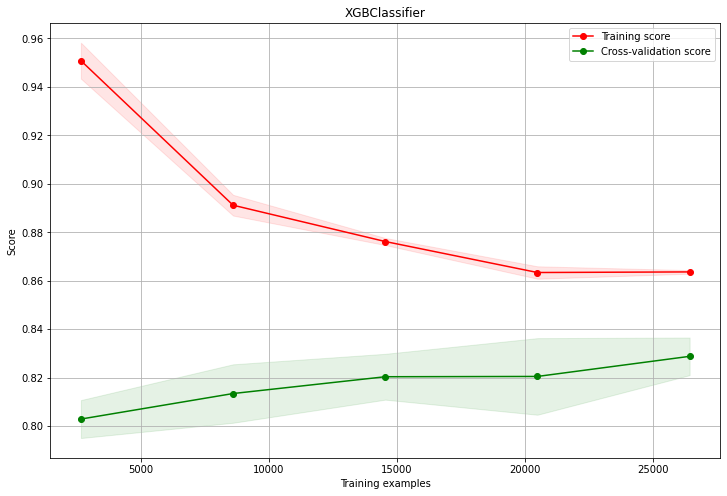

In [38]:
model = xgb.XGBClassifier(n_estimators=150, max_depth=6, random_state=2000)
train_and_predict(model, X, y, success_metric = rmsle, test_size=0.3)
plot_learning_curve(model, "XGBClassifier", X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))


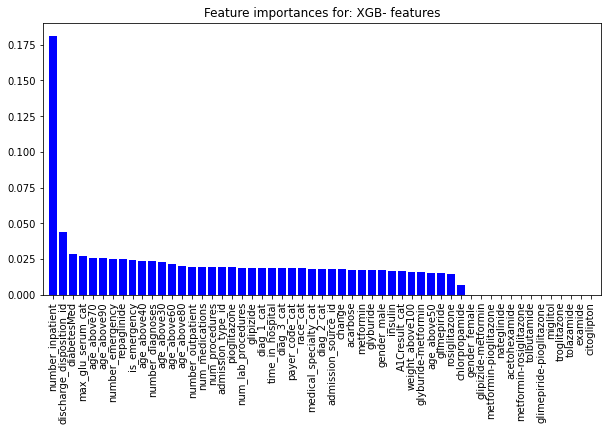

In [39]:
draw_feature_importances(model, features, "XGB- features")

##### Features from feature importances

In [40]:
features2 = ['number_inpatient', 'discharge_disposition_id', 'diabetesMed', 
             'max_glu_serum_cat', 'age_above70', 'age_above90', 
             'number_emergency', 'repaglinide', 'is_emergency', 'age_above40', 
             'number_diagnoses', 'age_above30', 'age_above60', 'age_above80', 
             'number_outpatient', 'num_medications', 'num_procedures', 
             'admission_type_id', 'pioglitazone', 'glipizide', 'diag_1_cat', 
             'time_in_hospital', 'diag_3_cat', 'payer_code_cat', 'race_cat', 
             'medical_specialty_cat', 'diag_2_cat', 'admission_source_id', 
             'change', 'acarbose', 'metformin', 'glyburide', 'gender_male', 
             'insulin', 'A1Cresult_cat', 'weight_above100', 'glyburide-metformin', 
             'age_above50', 'glimepiride', 'rosiglitazone', 'chlorpropamide'
             ]

In [41]:
X = train[features2].values
y = train['readmitted'].values

1.887


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

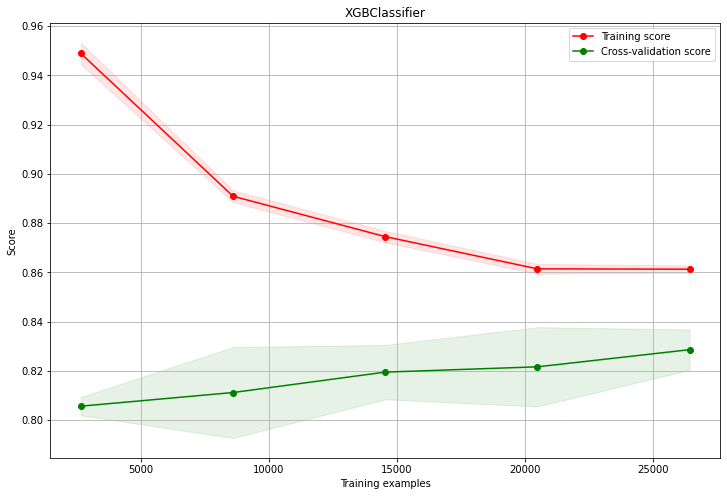

In [42]:
model = xgb.XGBClassifier(n_estimators=150, max_depth=6, random_state=2000)
train_and_predict(model, X, y, success_metric = rmsle, test_size=0.3)
plot_learning_curve(model, "XGBClassifier", X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))

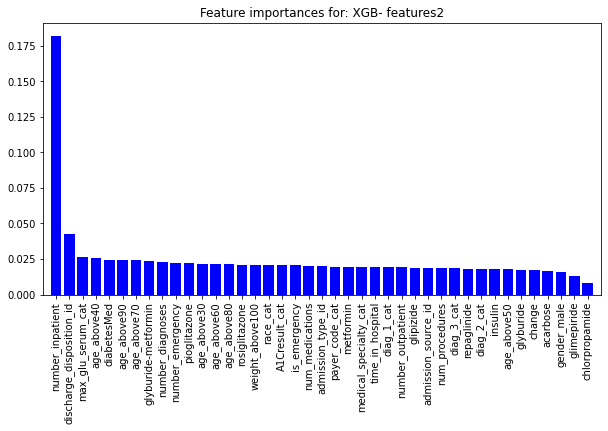

In [43]:
draw_feature_importances(model, features2, "XGB- features2")

1.894


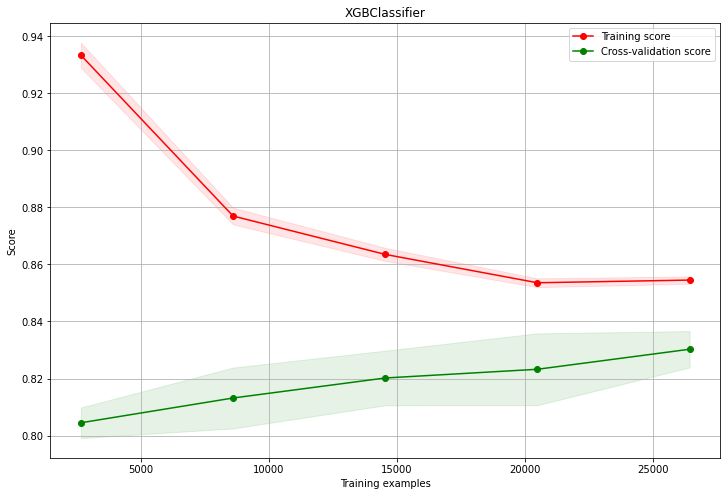

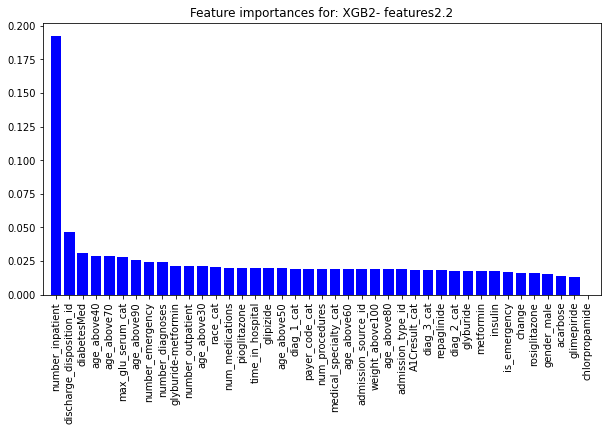

In [44]:

model = xgb.XGBClassifier(n_estimators=200, max_depth=5, random_state=2000)
train_and_predict(model, X, y, success_metric = rmsle, test_size=0.3)
plot_learning_curve(model, "XGBClassifier", X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))

draw_feature_importances(model, features2, "XGB2- features2.2")

1.886


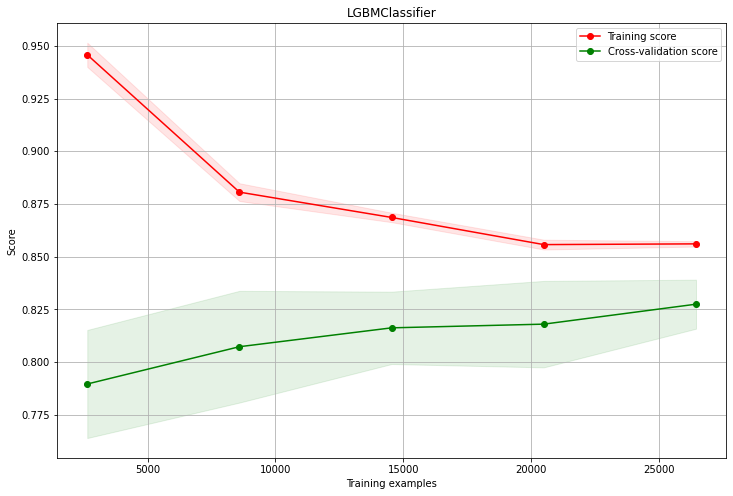

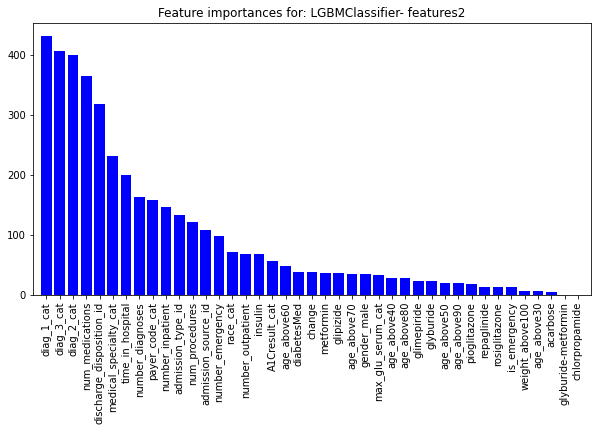

In [45]:
model = lgb.LGBMClassifier(max_depth=6, n_estimators=150, random_state=2000)
train_and_predict(model, X, y, success_metric = rmsle, test_size=0.3)
plot_learning_curve(model, "LGBMClassifier", X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))

draw_feature_importances(model, features2, "LGBMClassifier- features2")

Nowe cechy na podstawie feature importance dla LGBMClassifier

In [46]:
train.groupby(['number_inpatient'])['readmitted'].mean().reset_index()

,number_inpatient,readmitted
0,0,12.207704
1,1,22.684941
2,2,32.956298
3,3,41.920375
4,4,47.512438
5,5,64.532020
6,6,70.689655
7,7,61.971831
8,8,78.947368
9,9,74.074074


In [47]:
train['high_risk_num_inpatient'] = train['number_inpatient'].map(lambda x: int( (x == 11) | (x == 14) | (x == 15) | (x == 16) | (x == 19)))
train['risk_num_inpatient'] = train['number_inpatient'].map(lambda x: int( (x == 6) | (x == 8) | (x == 9) | (x == 10) | (x == 13)))

In [48]:
# pd.pivot_table(train, index=["readmitted"], values=['diag_1_cat', 'diag_2_cat', 'diag_3_cat'], aggfunc=["mean", "min", "max"] )

In [49]:
features4 = ['diag_1_cat', 'diag_2_cat', 'diag_3_cat', 'num_medications', 
             'discharge_disposition_id', 'medical_specialty_cat', 
             'time_in_hospital', 'number_diagnoses', 'payer_code_cat', 
             'number_inpatient', 'admission_type_id', 'num_procedures', 
             'admission_source_id', 'number_emergency', 'race_cat', 
             'number_outpatient', 'insulin', 'A1Cresult_cat', 'age_above60', 
             'diabetesMed', 'change', 'metformin',  'glipizide', 'age_above70', 
             'gender_male', 'max_glu_serum_cat', 'age_above40', 'age_above80', 
             'glimepiride', 'age_above50', 'age_above90', 'pioglitazone', 
             'repaglinide', 'is_emergency', 'weight_above100', 
             'high_risk_num_inpatient', 'risk_num_inpatient'
             ]


1.888


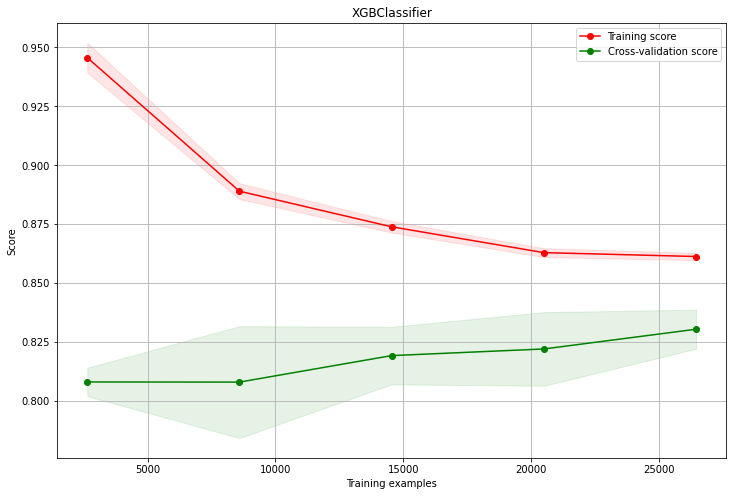

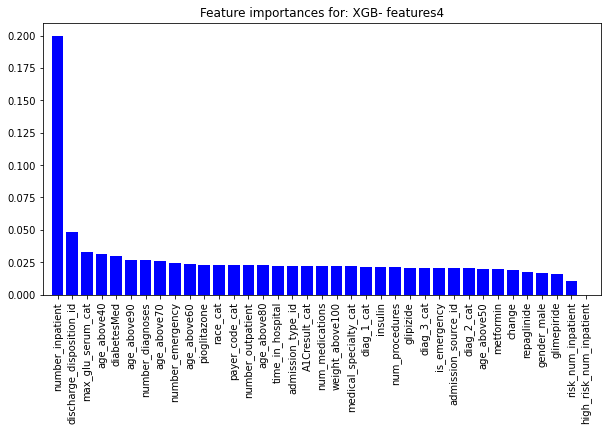

In [50]:

X = train[features4].values
y = train['readmitted'].values

model = xgb.XGBClassifier(n_estimators=150, max_depth=6, random_state=2000)
train_and_predict(model, X, y, success_metric = rmsle, test_size=0.3)
plot_learning_curve(model, "XGBClassifier", X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))

draw_feature_importances(model, features4, "XGB- features4")

1.877


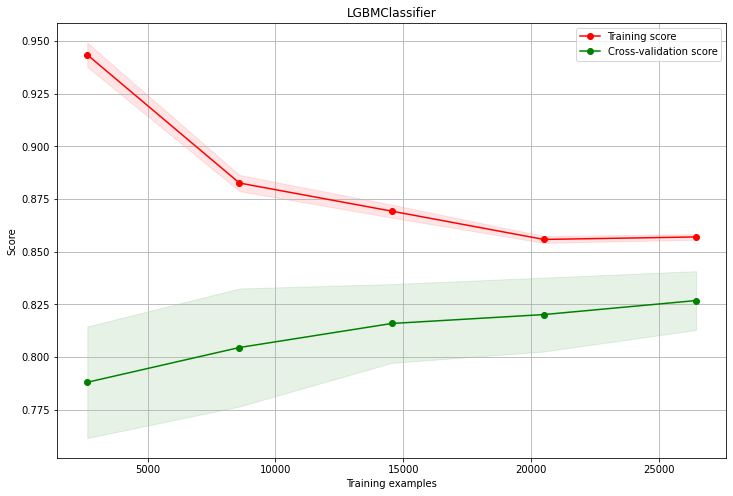

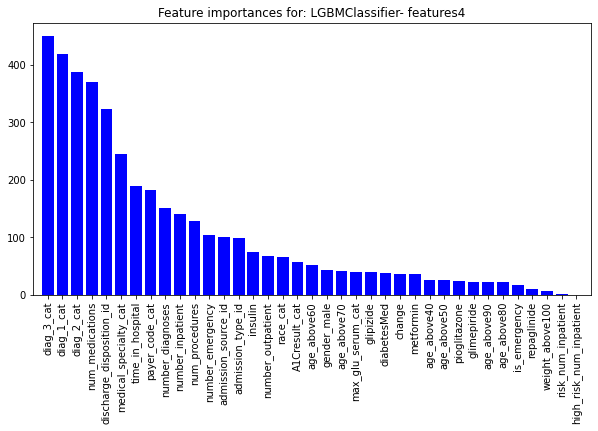

In [51]:
model = lgb.LGBMClassifier(max_depth=6, n_estimators=150, random_state=2000)
train_and_predict(model, X, y, success_metric = rmsle, test_size=0.3)
plot_learning_curve(model, "LGBMClassifier", X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))

draw_feature_importances(model, features4, "LGBMClassifier- features4")